# Method 2 - Best Ideas Low Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[best_ideas['herf_pct'] < (1 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

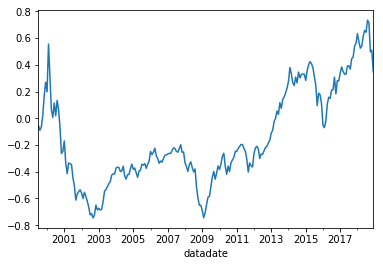

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.270092
2000-12-31   -0.406669
2001-12-31   -0.383491
2002-12-31   -0.324242
2003-12-31    0.855913
2004-12-31    0.127561
2005-12-31    0.033849
2006-12-31    0.066972
2007-12-31    0.032794
2008-12-31   -0.532721
2009-12-31    0.838639
2010-12-31    0.169544
2011-12-31   -0.155247
2012-12-31    0.314151
2013-12-31    0.468554
2014-12-31    0.084274
2015-12-31   -0.165735
2016-12-31    0.153263
2017-12-31    0.218771
2018-12-31   -0.136164
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     329.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.15e-93
Time:                        23:01:26   Log-Likelihood:                 477.32
No. Observations:                 234   AIC:                            -944.6
Df Residuals:                     229   BIC:                            -927.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.519      0.605      -0.003       0.005
mktrf          1.1325      0.059     19.088      0.000       1.016       1.249
me             0.5731      0.069      8.305      0.000       0.437       0.709
ia            -0.2800      0.105     -2.670      0.008      -0.487      -0.073
roe           -0.7395      0.090     -8.236      0.000      -0.916      -0.563
==============================================================================
Omnibus:                       23.297   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.422
Skew:                           0.431   Prob(JB):                     5.60e-13
Kurtosis:                       5.246   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     378.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.22e-99
Time:                        23:01:26   Log-Likelihood:                 477.32
No. Observations:                 234   AIC:                            -944.6
Df Residuals:                     229   BIC:                            -927.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.003      0.449      0.654      -0.004       0.006
mktrf          1.1325      0.069     16.516      0.000       0.998       1.267
me             0.5731      0.098      5.835      0.000       0.381       0.766
ia            -0.2800      0.138     -2.035      0.042      -0.550      -0.010
roe           -0.7395      0.152     -4.849      0.000      -1.038      -0.441
==============================================================================
Omnibus:                       23.297   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.422
Skew:                           0.431   Prob(JB):                     5.60e-13
Kurtosis:                       5.246   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     638.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.35e-123
Time:                        23:01:26   Log-Likelihood:                 477.32
No. Observations:                 234   AIC:                            -944.6
Df Residuals:                     229   BIC:                            -927.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.451      0.652      -0.004       0.006
mktrf          1.1325      0.057     19.967      0.000       1.021       1.244
me             0.5731      0.094      6.128      0.000       0.390       0.756
ia            -0.2800      0.124     -2.258      0.024      -0.523      -0.037
roe           -0.7395      0.155     -4.766      0.000      -1.044      -0.435
==============================================================================
Omnibus:                       23.297   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.422
Skew:                           0.431   Prob(JB):                     5.60e-13
Kurtosis:                       5.246   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     274.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.38e-94
Time:                        23:01:26   Log-Likelihood:                 481.98
No. Observations:                 234   AIC:                            -952.0
Df Residuals:                     228   BIC:                            -931.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.499      0.618      -0.003       0.005
mktrf          1.2000      0.058     20.548      0.000       1.085       1.315
smb            0.5277      0.077      6.848      0.000       0.376       0.679
hml           -0.1163      0.091     -1.280      0.202      -0.295       0.063
rmw           -0.8098      0.103     -7.883      0.000      -1.012      -0.607
cma            0.1022      0.131      0.783      0.435      -0.155       0.359
==============================================================================
Omnibus:                       14.650   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.263
Skew:                           0.415   Prob(JB):                     2.41e-05
Kurtosis:                       4.222   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     239.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.33e-88
Time:                        23:01:26   Log-Likelihood:                 481.98
No. Observations:                 234   AIC:                            -952.0
Df Residuals:                     228   BIC:                            -931.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.480      0.631      -0.003       0.005
mktrf          1.2000      0.059     20.204      0.000       1.084       1.316
smb            0.5277      0.053      9.956      0.000       0.424       0.632
hml           -0.1163      0.149     -0.781      0.435      -0.408       0.176
rmw           -0.8098      0.134     -6.054      0.000      -1.072      -0.548
cma            0.1022      0.137      0.745      0.456      -0.167       0.371
==============================================================================
Omnibus:                       14.650   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.263
Skew:                           0.415   Prob(JB):                     2.41e-05
Kurtosis:                       4.222   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     287.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.38e-96
Time:                        23:01:26   Log-Likelihood:                 481.98
No. Observations:                 234   AIC:                            -952.0
Df Residuals:                     228   BIC:                            -931.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.542      0.587      -0.003       0.005
mktrf          1.2000      0.064     18.679      0.000       1.074       1.326
smb            0.5277      0.049     10.874      0.000       0.433       0.623
hml           -0.1163      0.118     -0.987      0.324      -0.347       0.115
rmw           -0.8098      0.125     -6.461      0.000      -1.055      -0.564
cma            0.1022      0.118      0.869      0.385      -0.128       0.333
==============================================================================
Omnibus:                       14.650   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.263
Skew:                           0.415   Prob(JB):                     2.41e-05
Kurtosis:                       4.222   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     279.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.37e-87
Time:                        23:01:26   Log-Likelihood:                 461.27
No. Observations:                 234   AIC:                            -912.5
Df Residuals:                     229   BIC:                            -895.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.002     -0.827      0.409      -0.006       0.003
mktrf          1.3121      0.059     22.429      0.000       1.197       1.427
smb            0.8519      0.073     11.666      0.000       0.708       0.996
hml           -0.2351      0.073     -3.241      0.001      -0.378      -0.092
umd           -0.1816      0.048     -3.816      0.000      -0.275      -0.088
==============================================================================
Omnibus:                       33.960   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.641
Skew:                           0.821   Prob(JB):                     1.36e-12
Kurtosis:                       4.706   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     263.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.92e-84
Time:                        23:01:26   Log-Likelihood:                 461.27
No. Observations:                 234   AIC:                            -912.5
Df Residuals:                     229   BIC:                            -895.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.002     -0.818      0.413      -0.006       0.003
mktrf          1.3121      0.065     20.200      0.000       1.185       1.439
smb            0.8519      0.106      8.007      0.000       0.643       1.060
hml           -0.2351      0.098     -2.400      0.016      -0.427      -0.043
umd           -0.1816      0.077     -2.352      0.019      -0.333      -0.030
==============================================================================
Omnibus:                       33.960   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.641
Skew:                           0.821   Prob(JB):                     1.36e-12
Kurtosis:                       4.706   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     226.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.88e-78
Time:                        23:01:26   Log-Likelihood:                 461.27
No. Observations:                 234   AIC:                            -912.5
Df Residuals:                     229   BIC:                            -895.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.002     -0.868      0.385      -0.006       0.002
mktrf          1.3121      0.065     20.147      0.000       1.184       1.440
smb            0.8519      0.094      9.061      0.000       0.668       1.036
hml           -0.2351      0.089     -2.648      0.008      -0.409      -0.061
umd           -0.1816      0.079     -2.300      0.021      -0.336      -0.027
==============================================================================
Omnibus:                       33.960   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.641
Skew:                           0.821   Prob(JB):                     1.36e-12
Kurtosis:                       4.706   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     166.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.58e-47
Time:                        23:01:26   Log-Likelihood:                 225.43
No. Observations:                 120   AIC:                            -440.9
Df Residuals:                     115   BIC:                            -426.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.004     -0.110      0.912      -0.008       0.007
mktrf          1.1633      0.097     11.950      0.000       0.970       1.356
me             0.6342      0.096      6.596      0.000       0.444       0.825
ia            -0.3892      0.151     -2.585      0.011      -0.687      -0.091
roe           -0.6125      0.133     -4.596      0.000      -0.877      -0.349
==============================================================================
Omnibus:                       13.495   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.486
Skew:                           0.485   Prob(JB):                     7.94e-06
Kurtosis:                       4.938   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     281.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.27e-58
Time:                        23:01:26   Log-Likelihood:                 225.43
No. Observations:                 120   AIC:                            -440.9
Df Residuals:                     115   BIC:                            -426.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.005     -0.087      0.931      -0.009       0.009
mktrf          1.1633      0.104     11.228      0.000       0.960       1.366
me             0.6342      0.126      5.043      0.000       0.388       0.881
ia            -0.3892      0.209     -1.864      0.062      -0.799       0.020
roe           -0.6125      0.225     -2.725      0.006      -1.053      -0.172
==============================================================================
Omnibus:                       13.495   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.486
Skew:                           0.485   Prob(JB):                     7.94e-06
Kurtosis:                       4.938   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     543.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.17e-73
Time:                        23:01:26   Log-Likelihood:                 225.43
No. Observations:                 120   AIC:                            -440.9
Df Residuals:                     115   BIC:                            -426.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.005     -0.086      0.931      -0.009       0.009
mktrf          1.1633      0.078     14.904      0.000       1.010       1.316
me             0.6342      0.121      5.235      0.000       0.397       0.872
ia            -0.3892      0.202     -1.924      0.054      -0.786       0.007
roe           -0.6125      0.224     -2.730      0.006      -1.052      -0.173
==============================================================================
Omnibus:                       13.495   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.486
Skew:                           0.485   Prob(JB):                     7.94e-06
Kurtosis:                       4.938   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     161.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.27e-50
Time:                        23:01:26   Log-Likelihood:                 235.74
No. Observations:                 120   AIC:                            -459.5
Df Residuals:                     114   BIC:                            -442.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.003      0.551      0.583      -0.005       0.009
mktrf          1.2621      0.095     13.339      0.000       1.075       1.450
smb            0.5693      0.107      5.312      0.000       0.357       0.782
hml           -0.2291      0.131     -1.745      0.084      -0.489       0.031
rmw           -0.6818      0.155     -4.403      0.000      -0.989      -0.375
cma            0.1243      0.170      0.733      0.465      -0.212       0.460
==============================================================================
Omnibus:                        5.654   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.059   Jarque-Bera (JB):                6.480
Skew:                           0.277   Prob(JB):                       0.0392
Kurtosis:                       3.995   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     159.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.15e-50
Time:                        23:01:26   Log-Likelihood:                 235.74
No. Observations:                 120   AIC:                            -459.5
Df Residuals:                     114   BIC:                            -442.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.003      0.557      0.577      -0.005       0.008
mktrf          1.2621      0.082     15.417      0.000       1.102       1.423
smb            0.5693      0.069      8.253      0.000       0.434       0.704
hml           -0.2291      0.182     -1.256      0.209      -0.587       0.128
rmw           -0.6818      0.191     -3.572      0.000      -1.056      -0.308
cma            0.1243      0.162      0.767      0.443      -0.193       0.442
==============================================================================
Omnibus:                        5.654   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.059   Jarque-Bera (JB):                6.480
Skew:                           0.277   Prob(JB):                       0.0392
Kurtosis:                       3.995   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     220.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.89e-57
Time:                        23:01:27   Log-Likelihood:                 235.74
No. Observations:                 120   AIC:                            -459.5
Df Residuals:                     114   BIC:                            -442.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.003      0.619      0.536      -0.004       0.008
mktrf          1.2621      0.079     16.014      0.000       1.108       1.417
smb            0.5693      0.059      9.692      0.000       0.454       0.684
hml           -0.2291      0.149     -1.541      0.123      -0.520       0.062
rmw           -0.6818      0.189     -3.607      0.000      -1.052      -0.311
cma            0.1243      0.127      0.979      0.328      -0.125       0.373
==============================================================================
Omnibus:                        5.654   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.059   Jarque-Bera (JB):                6.480
Skew:                           0.277   Prob(JB):                       0.0392
Kurtosis:                       3.995   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     170.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.56e-47
Time:                        23:01:27   Log-Likelihood:                 226.42
No. Observations:                 120   AIC:                            -442.8
Df Residuals:                     115   BIC:                            -428.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.004     -0.370      0.712      -0.008       0.006
mktrf          1.3951      0.085     16.401      0.000       1.227       1.564
smb            0.8430      0.097      8.704      0.000       0.651       1.035
hml           -0.3177      0.097     -3.275      0.001      -0.510      -0.126
umd           -0.1281      0.060     -2.141      0.034      -0.247      -0.010
==============================================================================
Omnibus:                       13.161   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.304
Skew:                           0.630   Prob(JB):                     0.000288
Kurtosis:                       4.294   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     242.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.93e-55
Time:                        23:01:27   Log-Likelihood:                 226.42
No. Observations:                 120   AIC:                            -442.8
Df Residuals:                     115   BIC:                            -428.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.004     -0.367      0.714      -0.008       0.006
mktrf          1.3951      0.078     17.852      0.000       1.242       1.548
smb            0.8430      0.121      6.940      0.000       0.605       1.081
hml           -0.3177      0.101     -3.150      0.002      -0.515      -0.120
umd           -0.1281      0.084     -1.520      0.129      -0.293       0.037
==============================================================================
Omnibus:                       13.161   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.304
Skew:                           0.630   Prob(JB):                     0.000288
Kurtosis:                       4.294   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     389.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.54e-66
Time:                        23:01:27   Log-Likelihood:                 226.42
No. Observations:                 120   AIC:                            -442.8
Df Residuals:                     115   BIC:                            -428.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.003     -0.389      0.697      -0.008       0.005
mktrf          1.3951      0.060     23.424      0.000       1.278       1.512
smb            0.8430      0.112      7.543      0.000       0.624       1.062
hml           -0.3177      0.086     -3.699      0.000      -0.486      -0.149
umd           -0.1281      0.081     -1.579      0.114      -0.287       0.031
==============================================================================
Omnibus:                       13.161   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.304
Skew:                           0.630   Prob(JB):                     0.000288
Kurtosis:                       4.294   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     164.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.97e-45
Time:                        23:01:27   Log-Likelihood:                 267.00
No. Observations:                 114   AIC:                            -524.0
Df Residuals:                     109   BIC:                            -510.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.103      0.272      -0.002       0.007
mktrf          1.1286      0.070     16.138      0.000       0.990       1.267
me             0.4129      0.108      3.824      0.000       0.199       0.627
ia            -0.0813      0.150     -0.543      0.588      -0.378       0.216
roe           -1.0046      0.132     -7.634      0.000      -1.265      -0.744
==============================================================================
Omnibus:                       13.679   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.394
Skew:                           0.656   Prob(JB):                     0.000167
Kurtosis:                       4.393   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     233.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.91e-52
Time:                        23:01:27   Log-Likelihood:                 267.00
No. Observations:                 114   AIC:                            -524.0
Df Residuals:                     109   BIC:                            -510.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.432      0.152      -0.001       0.006
mktrf          1.1286      0.073     15.388      0.000       0.985       1.272
me             0.4129      0.073      5.628      0.000       0.269       0.557
ia            -0.0813      0.145     -0.559      0.576      -0.366       0.204
roe           -1.0046      0.161     -6.241      0.000      -1.320      -0.689
==============================================================================
Omnibus:                       13.679   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.394
Skew:                           0.656   Prob(JB):                     0.000167
Kurtosis:                       4.393   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     419.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.37e-65
Time:                        23:01:27   Log-Likelihood:                 267.00
No. Observations:                 114   AIC:                            -524.0
Df Residuals:                     109   BIC:                            -510.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.647      0.100      -0.000       0.006
mktrf          1.1286      0.070     16.222      0.000       0.992       1.265
me             0.4129      0.070      5.889      0.000       0.275       0.550
ia            -0.0813      0.141     -0.576      0.565      -0.358       0.196
roe           -1.0046      0.155     -6.469      0.000      -1.309      -0.700
==============================================================================
Omnibus:                       13.679   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.394
Skew:                           0.656   Prob(JB):                     0.000167
Kurtosis:                       4.393   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     93.99
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.05e-37
Time:                        23:01:27   Log-Likelihood:                 251.34
No. Observations:                 114   AIC:                            -490.7
Df Residuals:                     108   BIC:                            -474.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.003      0.044      0.965      -0.005       0.006
mktrf          1.1725      0.077     15.252      0.000       1.020       1.325
smb            0.4644      0.125      3.721      0.000       0.217       0.712
hml            0.0365      0.159      0.229      0.819      -0.279       0.352
rmw           -0.8490      0.195     -4.357      0.000      -1.235      -0.463
cma            0.1034      0.247      0.418      0.677      -0.387       0.594
==============================================================================
Omnibus:                       10.569   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.269
Skew:                           0.614   Prob(JB):                      0.00357
Kurtosis:                       3.930   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     132.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.77e-44
Time:                        23:01:27   Log-Likelihood:                 251.34
No. Observations:                 114   AIC:                            -490.7
Df Residuals:                     108   BIC:                            -474.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.002      0.049      0.961      -0.005       0.005
mktrf          1.1725      0.080     14.652      0.000       1.016       1.329
smb            0.4644      0.087      5.349      0.000       0.294       0.635
hml            0.0365      0.231      0.158      0.874      -0.417       0.490
rmw           -0.8490      0.314     -2.704      0.007      -1.465      -0.234
cma            0.1034      0.251      0.412      0.680      -0.388       0.595
==============================================================================
Omnibus:                       10.569   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.269
Skew:                           0.614   Prob(JB):                      0.00357
Kurtosis:                       3.930   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     163.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.07e-48
Time:                        23:01:27   Log-Likelihood:                 251.34
No. Observations:                 114   AIC:                            -490.7
Df Residuals:                     108   BIC:                            -474.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.002      0.059      0.953      -0.004       0.004
mktrf          1.1725      0.081     14.421      0.000       1.013       1.332
smb            0.4644      0.078      5.943      0.000       0.311       0.618
hml            0.0365      0.240      0.152      0.879      -0.434       0.507
rmw           -0.8490      0.299     -2.837      0.005      -1.436      -0.262
cma            0.1034      0.280      0.370      0.711      -0.445       0.651
==============================================================================
Omnibus:                       10.569   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.269
Skew:                           0.614   Prob(JB):                      0.00357
Kurtosis:                       3.930   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     107.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.11e-37
Time:                        23:01:27   Log-Likelihood:                 246.61
No. Observations:                 114   AIC:                            -483.2
Df Residuals:                     109   BIC:                            -469.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.003     -0.130      0.897      -0.006       0.005
mktrf          1.1943      0.079     15.069      0.000       1.037       1.351
smb            0.6713      0.124      5.433      0.000       0.426       0.916
hml            0.0808      0.127      0.635      0.527      -0.171       0.333
umd           -0.2877      0.096     -2.996      0.003      -0.478      -0.097
==============================================================================
Omnibus:                       14.394   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.204
Skew:                           0.727   Prob(JB):                     0.000184
Kurtosis:                       4.228   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     123.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.76e-39
Time:                        23:01:27   Log-Likelihood:                 246.61
No. Observations:                 114   AIC:                            -483.2
Df Residuals:                     109   BIC:                            -469.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.160      0.873      -0.005       0.004
mktrf          1.1943      0.086     13.834      0.000       1.025       1.363
smb            0.6713      0.102      6.583      0.000       0.471       0.871
hml            0.0808      0.211      0.383      0.702      -0.333       0.494
umd           -0.2877      0.102     -2.812      0.005      -0.488      -0.087
==============================================================================
Omnibus:                       14.394   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.204
Skew:                           0.727   Prob(JB):                     0.000184
Kurtosis:                       4.228   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     164.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.51e-45
Time:                        23:01:27   Log-Likelihood:                 246.61
No. Observations:                 114   AIC:                            -483.2
Df Residuals:                     109   BIC:                            -469.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.177      0.860      -0.004       0.004
mktrf          1.1943      0.086     13.957      0.000       1.027       1.362
smb            0.6713      0.087      7.760      0.000       0.502       0.841
hml            0.0808      0.220      0.366      0.714      -0.351       0.513
umd           -0.2877      0.089     -3.230      0.001      -0.462      -0.113
==============================================================================
Omnibus:                       14.394   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.204
Skew:                           0.727   Prob(JB):                     0.000184
Kurtosis:                       4.228   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""